In [ ]:
import numpy as np
import matplotlib.pyplot as plt 
from os import listdir

## Initial Sample of S82 CRTS QSO  from Branimir 

First, find how many quasars we got from Branimir : in ~/SDSS/   I find  QSO_CRTS.tar.gz   and QSO_CRTS.tar  - these are  one and the same archives that we start with  
I extract them to QSO_CRTS/ 

In [1]:
pwd

u'/astro/users/suberlak/Desktop/SDSS'

In [81]:
dir_1 = 'QSO_CRTS/'

In [82]:
QSO_list = listdir(dir_1)

In [83]:
print('We have %d quasars to start with ' % len(QSO_list))

We have 7932 quasars to start with 


## Remove empty files and those with less than 10 points 

Three equivalent ways of testing for the number of empty files.  Those files should be removed from the list of accepted QSO/ 

In [48]:
c = 0 
empty_files = []
for obj in QSO_list:
    address = dir_1 + obj
    f = open(address, 'r')
    if f.readline() == '' :
        c += 1
        empty_files.append(obj)
        
print('We have %d empty files' % c)    

We have 179 empty files


In [ ]:
#import os
#d = 0
#for obj in QSO_list:
#    address = dir_1 + obj
#    if os.stat(address).st_size == 0 : 
#        d += 1 

In [39]:
#e = 0   
#for obj in QSO_list :
#    address = dir_1 + obj
#    if not (os.path.getsize(address) > 0) : 
#        e += 1 

179

In [86]:
QSO_nonempty = np.array(QSO_list)[~np.in1d(QSO_list, empty_files)]  
len(QSO_nonempty)

7753

Remove those files that have less than 10 points : 

In [62]:
c = 0 
short_files = []
for obj in QSO_nonempty:
    address = dir_1 + obj
    f = open(address, 'r')
    num_lines = sum(1 for line in open(dir_1+obj))
    if num_lines < 10 :
        c += 1
        short_files.append(obj)
        
print('We have %d  files with less than 10 pts ' % c) 

We have 46  files with less than 10 pts 


In [87]:
QSO_10_pts_plus = QSO_nonempty[~np.in1d(QSO_nonempty, short_files)]
len(QSO_10_pts_plus)

7707

This list of  files is identical to files in QSO_CRTS_LC_longer_10/  : 


In [88]:
dir_2 = 'QSO_CRTS_LC_longer_10/'

In [89]:
QSO_2_list = listdir(dir_2)

In [90]:
QSO_10_pts_plus[~np.in1d(QSO_10_pts_plus,QSO_2_list)]

array([], 
      dtype='|S22')

Calculating statistics for the day-averaged processed sample of Quasars . Based on qso_crts_preprocessing.py

In [2]:
def update_progress(progress):
    ''' A simple function updating the time progress. 
    Inspired by 
    http://stackoverflow.com/questions/3173320/text-progress-bar-in-the-console 
    Parameters
    -----------
    progress : a value (float or int) between 0 and 100 indicating 
               percentage progress 
    Returns
    ----------
    None
    '''
    print '\r[%-10s] %0.2f%%' % ('#' * int(progress/10), progress),
   

### Day-averaged light curves : needs be RUN ONLY ONCE  to make them!

Make day-averaged lightcurves, save only if more than 10 observing days (points in the day-averaged light curve). 
Save MJD, avg_mag, error, N_obs that day. For our 7707 lightcurves it takes about 1.5 mins on my workstation. 

In [57]:


dir_in = 'QSO_CRTS_LC_longer_10/'
dir_err_w = 'QSO_CRTS_LC_day_averaged_err_w/'
lc_files = np.array(listdir(dir_in))

k = 0
total = float(len(lc_files))

for obj in lc_files:
    percent = 100*(k / total)
    if (k % 10) == 0 : # every tenth loop.. 
        update_progress(int(percent))
    k += 1
    
    address=dir_in+obj
    data=np.loadtxt(address)

    averages=np.zeros(shape=(len(data),3))

    mjd = data[:,0]
    mags = data[:,1]
    errs = data[:,2]
   
    days = np.unique([int(day) for day in data[:,0]])
    
    # storage arrays  for each qso (all N's)
    mjd_arr = np.zeros_like(days).astype(float)
    avg_mags = np.zeros_like(days).astype(float)
    avg_err_weights = np.zeros_like(days).astype(float)  
    Nobs = np.zeros_like(days).astype(float)

    # loop through days calculating mean, etc. 
    for i in range(len(days)):
        day = days[i]
        int_mjd = np.require(mjd,int)       # forcing mjd array -> integers
        condition = (int_mjd == day)        # finding where int(mjd) = day
        N = float(len(mags[condition]))            # number of obs in that night 
        Nobs[i] = N
        avgmag = np.average(mags[condition],weights=errs[condition]) # works for single measurement too ! 
        
        # weights error : only that was used in the end 
        weights=1.0 / ( errs[condition] * errs[condition]) 
        avg_mags[i] = avgmag
        error_weights = 1.0 / np.sqrt(np.sum(weights))
        
        # increase error if too small 
        if error_weights < 0.02 : 
            error_weights = np.sqrt(error_weights**2.0 + 0.01**2.0)  
            
        avg_err_weights[i] = error_weights
      
        mjd_arr[i] = np.mean(mjd[condition])
        
    # Save the output... 
    # Once per lightcurve 
    # ONLY IF THERE IS MORE THAN 10 OBS ! 
    
    if( len(mjd_arr) >  10 ) :
            name_out = dir_err_w + 'out_'+obj[:18]+'.txt'
    
    # So now we are saving all the day-averaged LC's, even if the resulting length was less than 10 days... 
    # Easier to explain stats if they are ignored later. 

    # Then select only those that have more than 10 days of observations, and 
    # compare to content of the QSO_CRTS_processed_err_w/ directory, to ensure that they are the same
    np.savetxt(name_out, np.column_stack((mjd_arr,avg_mags, avg_err_weights, Nobs)),fmt='%11.4f')
    
       

[######### ] 99.00%


### Statistics of the day-averaged light curves (read-in previously made LCs) 

Find out what are the stats for the 7601 quasar light curves that are longer than 10 days. 
Each lightcurve has three columns :
MJD, average_magnitude,  error (as calculated above), N_points_per_day

In [3]:
dir_err_w = 'QSO_CRTS_LC_day_averaged_err_w/'
files = np.array(listdir(dir_err_w))

# make an array for storing total timespan of obs per object, 
# as well as the total number of nights per object
timespan_obs = np.zeros_like(files, dtype=float) # store what was the total  timespan of observations per object
lc_length=np.zeros_like(files, dtype=float) # number of points in the lightcurve - equal to the number of obs nights
avg_N_day = np.zeros_like(files, dtype=float)
avg_mag_ttl= np.zeros_like(files, dtype=float)
avg_err_ttl= np.zeros_like(files, dtype=float)
avg_mjd_diff= np.zeros_like(files, dtype=float)

k = 0
total = float(len(files))

for i in range(len(files)):
    percent = 100*(k / total)
    if (k % 10) == 0 : # every tenth loop.. 
        update_progress(int(percent))
    k += 1
    
    address=dir_err_w+files[i]  
    data=np.loadtxt(address) 
    
    lc_length[i] = sum(1 for line in open(address))
    avg_mag_ttl[i] = np.mean(data[:,1])
    avg_err_ttl[i] = np.mean(data[:,2])
    avg_N_day[i] = np.mean(data[:,3])
    timespan_obs[i] = data[-1,0]-data[0,0]  # gives number of days between first and last obs
    
    
    # the 
    mjd_diff = np.zeros(len(data[:,0]))
    for j in range(len(data)-1):
        mjd_diff[j] = data[j+1,0] - data[j,0]
    avg_mjd_diff[i] = np.mean(mjd_diff)     # avg span between obs in MJD      

keys = ['timespan_obs', 'lc_length', 'avg_N_day', 'avg_mag_ttl', 'avg_err_ttl', 'avg_mjd_diff']
values = [timespan_obs,lc_length,avg_N_day,avg_mag_ttl,avg_err_ttl,avg_mjd_diff]


stats_dict={}
for key, value in zip(keys, values):
    stats_dict[key] = value
    

[######### ] 99.00%


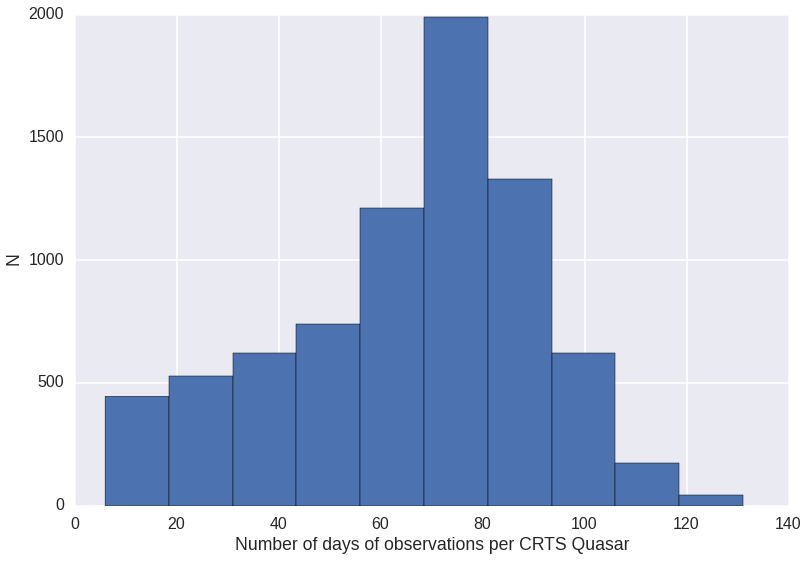

In [18]:
%matplotlib inline

import seaborn as sns
sns.set_context('poster')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylabel('N')
ax.set_xlabel('Number of days of observations per CRTS Quasar')
ax.hist(stats_dict['lc_length'])
plt.savefig('QSO_CRTS_AVG_stats_lc_length.png')

In [42]:
# What is the mean number of days per Quasar ? 
print(np.mean(lc_length))

65.3354093681


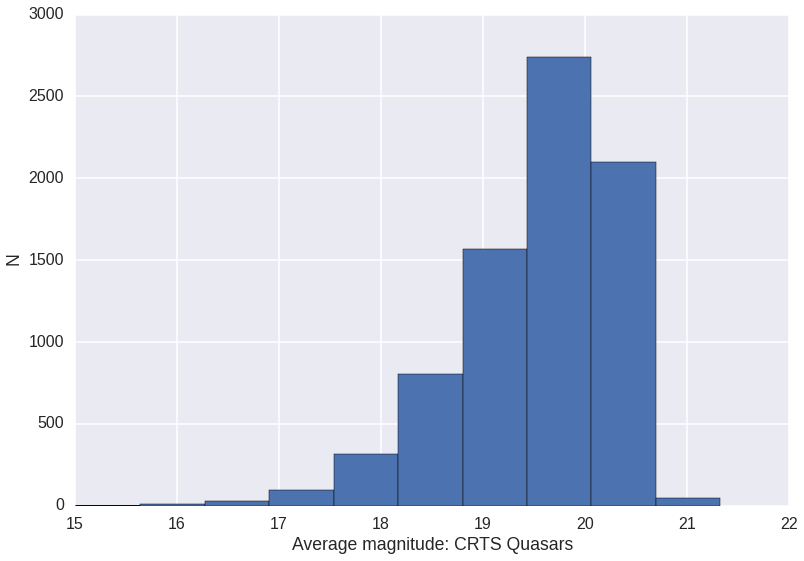

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylabel('N')
ax.set_xlabel('Average magnitude: CRTS Quasars')
ax.hist(stats_dict['avg_mag_ttl'])
plt.savefig('QSO_CRTS_AVG_stats_avg_mag.png')

In [46]:
# What is the mean and median magnitude ? 
print(np.mean(avg_mag_ttl))
print(np.median(avg_mag_ttl))

19.5400667526
19.708772


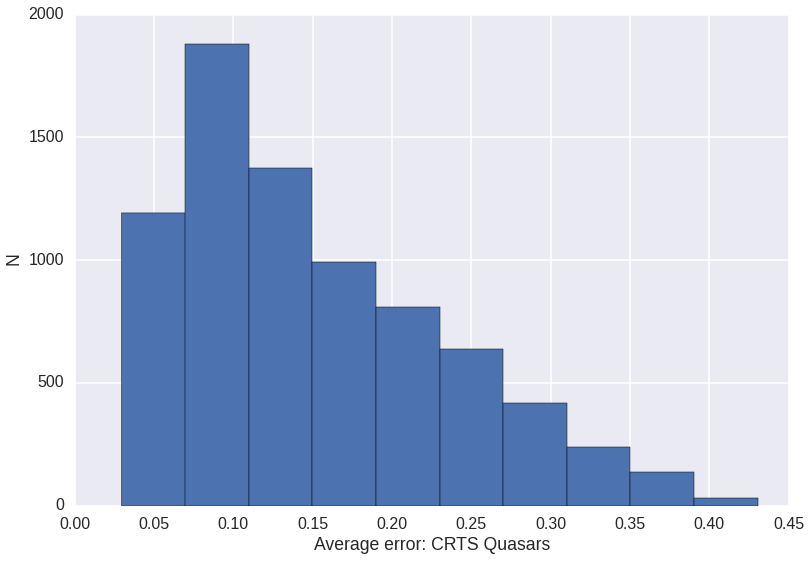

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylabel('N')
ax.set_xlabel('Average error: CRTS Quasars')
ax.hist(stats_dict['avg_err_ttl'])
plt.savefig('QSO_CRTS_AVG_stats_avg_err.png')

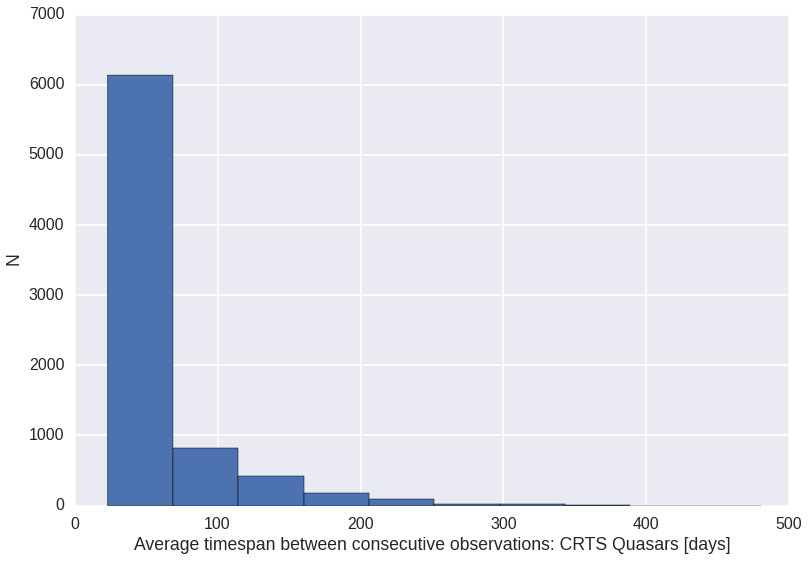

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylabel('N')
ax.set_xlabel('Average timespan between consecutive observations: CRTS Quasars [days]')
ax.hist(stats_dict['avg_mjd_diff'])
plt.savefig('QSO_CRTS_AVG_observations_cadence.png')

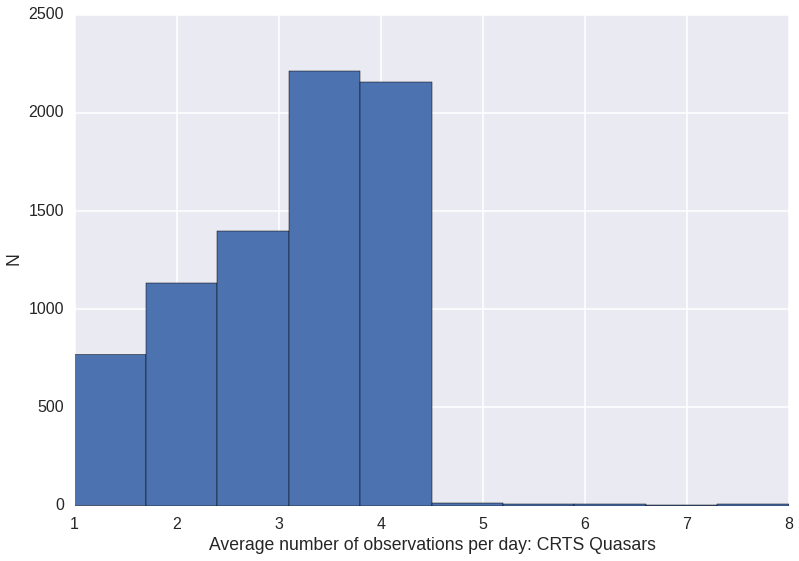

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylabel('N')
ax.set_xlabel('Average number of observations per day: CRTS Quasars')
ax.hist(stats_dict['avg_N_day'])
plt.savefig('QSO_CRTS_AVG_N_obs_per_day.png')

In [23]:
# How many lightcurves have on average more than 4 day of obs per day ? 
np.sum(avg_N_day > 4)

293

In [24]:
# How many lightcurves have less than 10 days of obs ? 
np.sum(lc_length < 10)

90

In [25]:
# How many lightcurves have between 1 and 4 obs ? 
np.sum((avg_N_day < 4) * (avg_N_day >1))

7035

In [26]:
len(avg_N_day)

7707

### Sanity check : plot light curves... 

For diagnostics : print the averaged LC  

QSO_CRTS_LC_day_averaged_err_w/out_235948.09+001229.5.txt


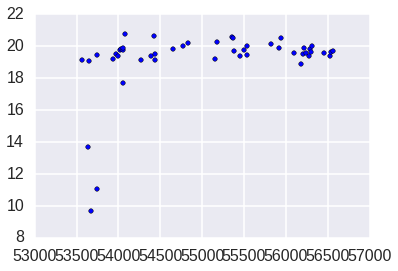

In [43]:
%matplotlib inline 
i=0
address=dir_err_w+files[i]  
data=np.loadtxt(address) 
plt.scatter(data[:,0], data[:,1])
print address

And print the original LC.... 

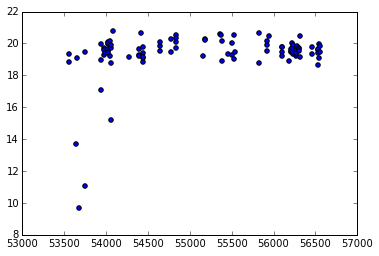

In [37]:
address = 'QSO_CRTS_LC_longer_10/' + files[i][4:-3]+'dat'
data=np.loadtxt(address) 
plt.scatter(data[:,0], data[:,1])

In [58]:
# Check whether this happens often... calculate the scatter of points...

rms = np.sqrt(np.mean(np.square(data[:,1])))

In [62]:
scatt = np.zeros_like(files, dtype=float)

for i in range(len(files)):
    address=dir_err_w+files[i]  
    data=np.loadtxt(address) 
    scatt[i] = np.mean(data[:,1]) - min(data[:,1])

Number of light curves affected :
353


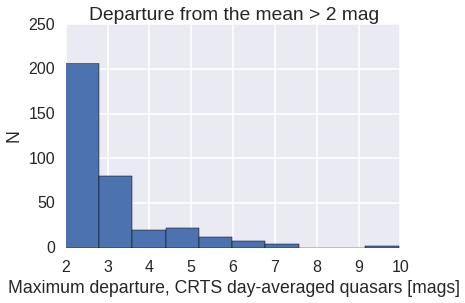

In [74]:
cutoff = 2 # how many mags away from the mean can the farthest point be? 
print('Number of light curves affected :')
print(np.sum(scatt>cutoff))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('Departure from the mean > '+str(cutoff)+' mag')
ax.set_ylabel('N')
ax.set_xlabel('Maximum departure, CRTS day-averaged quasars [mags]')
ax.hist(scatt[scatt>cutoff])
plt.savefig('QSO_CRTS_AVG_scatter_from_the_mean.png')


## Sanity check : compare to stats of  QSO_CRTS_processed_err_w LC's

Calculate the statistical info of those processed day-averaged light curves that I used before, from QSO_CRTS_processed_err_w.tar.gz . It is exactly the same number of lightcurves, so the selection works identically and predictably. 

In [5]:
dir_err_w = 'QSO_CRTS_processed_err_w/'
files = np.array(listdir(dir_err_w))

# make an array for storing total timespan of obs per object, 
# as well as the total number of nights per object
timespan_obs = np.zeros_like(files, dtype=float) # store what was the total  timespan of observations per object
lc_length=np.zeros_like(files, dtype=float) # number of points in the lightcurve - equal to the number of obs nights
#avg_N_day = np.zeros_like(files, dtype=float)
avg_mag_ttl= np.zeros_like(files, dtype=float)
avg_err_ttl= np.zeros_like(files, dtype=float)
avg_mjd_diff= np.zeros_like(files, dtype=float)

k = 0
total = float(len(files))

for i in range(len(files)):
    percent = 100*(k / total)
    if (k % 10) == 0 : # every tenth loop.. 
        update_progress(int(percent))
    k += 1
    
    address=dir_err_w+files[i]  
    data=np.loadtxt(address) 
    
    lc_length[i] = sum(1 for line in open(address))
    avg_mag_ttl[i] = np.mean(data[:,1])
    avg_err_ttl[i] = np.mean(data[:,2])
    #avg_N_day[i] = np.mean(data[:,3])
    assert data[-1,0] == max(data[:,0])
    assert data[0,0] == min(data[:,0])
    timespan_obs[i] = data[-1,0]-data[0,0]  # gives number of days between first and last obs
    # we assume it's sorted! 
    
    
    # the 
    mjd_diff = np.zeros(len(data[:,0]))
    for j in range(len(data)-1):
        mjd_diff[j] = data[j+1,0] - data[j,0]
    avg_mjd_diff[i] = np.mean(mjd_diff)     # avg span between obs in MJD      


stats_dict_old={'timespan_obs':timespan_obs,
               'lc_length' : lc_length,
               'avg_mag_ttl': avg_mag_ttl,
               'avg_err_ttl' :avg_err_ttl,
              'avg_mjd_diff' :  avg_mjd_diff }


[######### ] 99.00%


66.1345875543


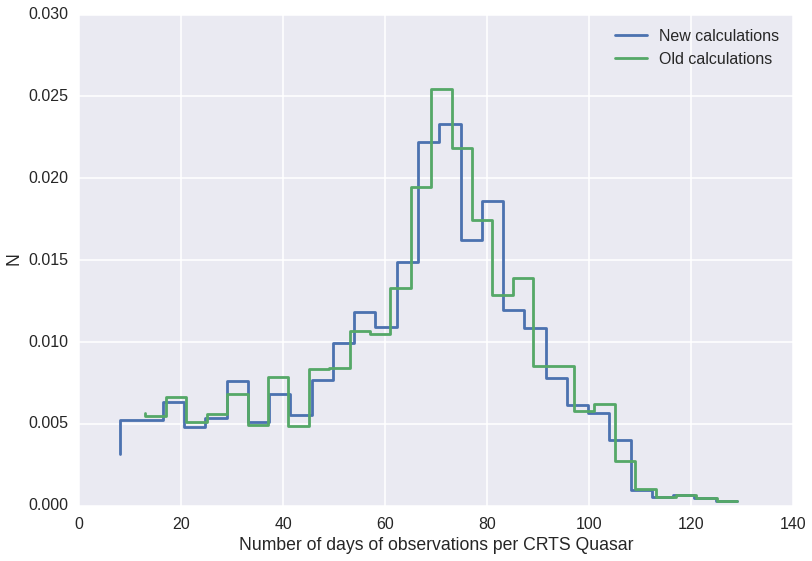

In [65]:
%matplotlib inline

import seaborn as sns
sns.set_context('poster')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylabel('N')
ax.set_xlabel('Number of days of observations per CRTS Quasar')

# Calculate the histogram1 : new day-averages
hist1, bin_edges = np.histogram(stats_dict['lc_length'], bins=nbins, density=True)
bin_centres1 = (bin_edges[:-1] + bin_edges[1:])/2

# Calculate the histogram2 : old day-averages
hist2, bin_edges = np.histogram(stats_dict_old['lc_length'], bins=nbins, density=True)
bin_centres2 = (bin_edges[:-1] + bin_edges[1:])/2

ax.plot(bin_centres1, hist1, ls = 'steps', label='New calculations')
ax.plot(bin_centres2, hist2, ls = 'steps', label='Old calculations')
ax.legend()

plt.savefig('QSO_CRTS_AVG_stats_lc_length_comp.png')

# What is the mean number of days per Quasar ? 
print(np.mean(lc_length))



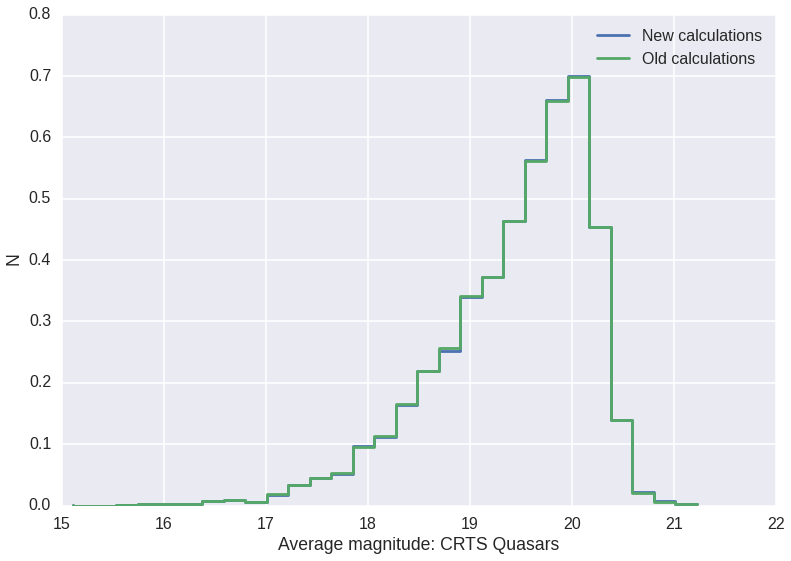

In [66]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylabel('N')
ax.set_xlabel('Average magnitude: CRTS Quasars')

nbins = 30

# Calculate the histogram1 : new day-averages
hist1, bin_edges = np.histogram(stats_dict['avg_mag_ttl'], bins=nbins, density=True)
bin_centres1 = (bin_edges[:-1] + bin_edges[1:])/2

# Calculate the histogram2 : old day-averages
hist2, bin_edges = np.histogram(stats_dict_old['avg_mag_ttl'], bins=nbins, density=True)
bin_centres2 = (bin_edges[:-1] + bin_edges[1:])/2

ax.plot(bin_centres1, hist1, ls = 'steps', label='New calculations')
ax.plot(bin_centres2, hist2, ls = 'steps', label='Old calculations')
ax.legend()

plt.savefig('QSO_CRTS_AVG_stats_avg_mag_comp.png')

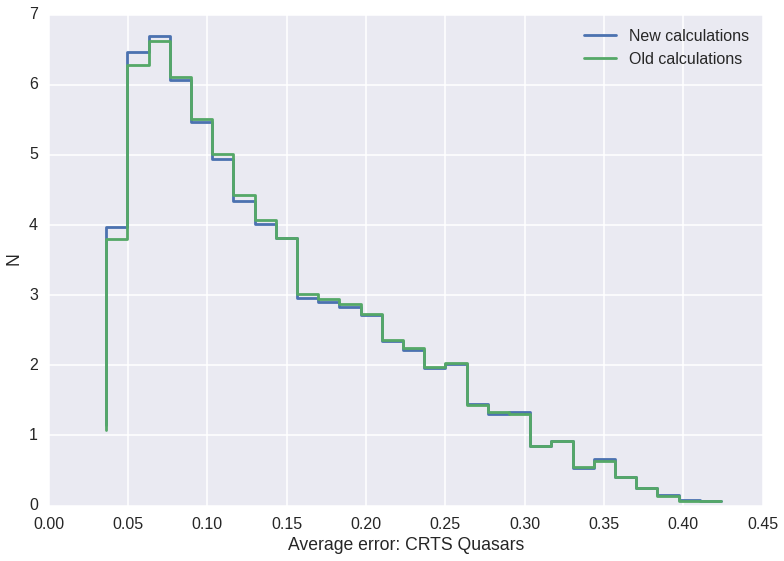

In [67]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylabel('N')
ax.set_xlabel('Average error: CRTS Quasars')

nbins = 30

# Calculate the histogram1 : new day-averages
hist1, bin_edges = np.histogram(stats_dict['avg_err_ttl'], bins=nbins, density=True)
bin_centres1 = (bin_edges[:-1] + bin_edges[1:])/2

# Calculate the histogram2 : old day-averages
hist2, bin_edges = np.histogram(stats_dict_old['avg_err_ttl'], bins=nbins, density=True)
bin_centres2 = (bin_edges[:-1] + bin_edges[1:])/2

ax.plot(bin_centres1, hist1, ls = 'steps', label='New calculations')
ax.plot(bin_centres2, hist2, ls = 'steps', label='Old calculations')
ax.legend()

plt.savefig('QSO_CRTS_AVG_stats_avg_err_comp.png')

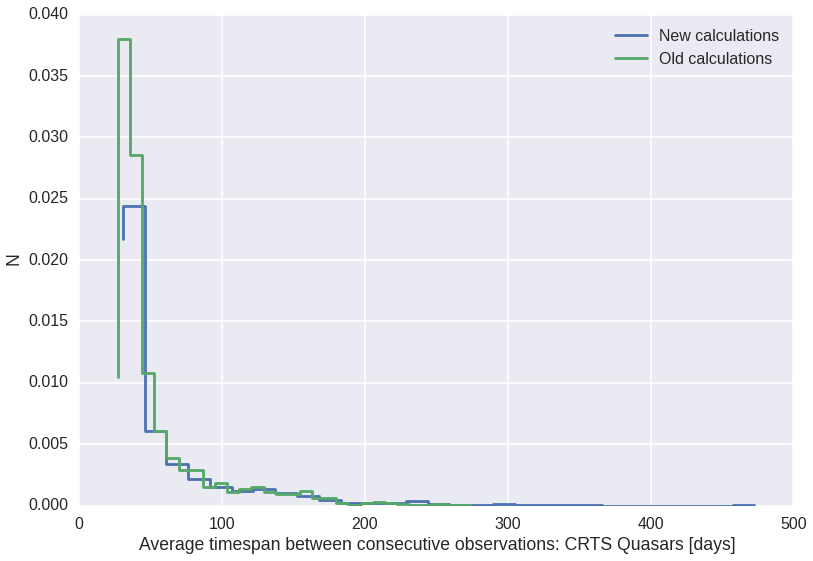

In [68]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylabel('N')
ax.set_xlabel('Average timespan between consecutive observations: CRTS Quasars [days]')

nbins = 30

# Calculate the histogram1 : new day-averages
hist1, bin_edges = np.histogram(stats_dict['avg_mjd_diff'], bins=nbins, density=True)
bin_centres1 = (bin_edges[:-1] + bin_edges[1:])/2

# Calculate the histogram2 : old day-averages
hist2, bin_edges = np.histogram(stats_dict_old['avg_mjd_diff'], bins=nbins, density=True)
bin_centres2 = (bin_edges[:-1] + bin_edges[1:])/2

ax.plot(bin_centres1, hist1, ls = 'steps', label='New calculations')
ax.plot(bin_centres2, hist2, ls = 'steps', label='Old calculations')
ax.legend()

plt.savefig('QSO_CRTS_AVG_observations_cadence_comp.png')

Note : Nobs per day cannot be compared between the old and new preprocessing (making day-averaged error-weigted light curves), because this information was not stored anywhere when making them for the first time... 

But otherwise, it looks pretty nice ! It seems that I am getting almost exactly the same with my current day-averaging... However, I am suprised that they are not exactly the same..e

## Make a four-panel stats plot only about data that were actually used... 

CRTS Quasars: sample of 7601


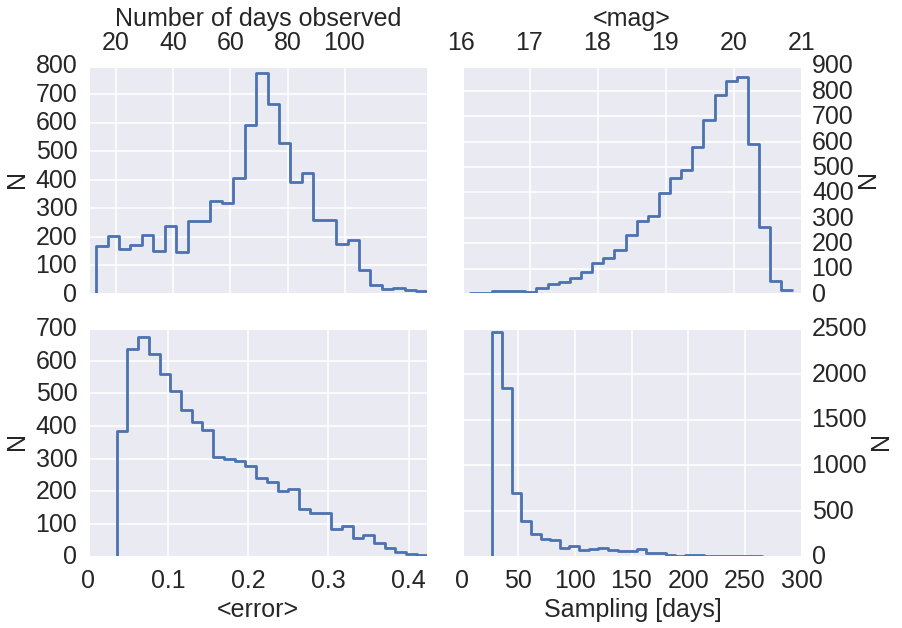

In [31]:
%matplotlib inline

import seaborn as sns
sns.set_context('poster')
from matplotlib import rcParams
rcParams['ytick.labelsize'] = 25
rcParams['xtick.labelsize'] = 25
rcParams['axes.labelsize'] = 25
rcParams['axes.linewidth'] = 3
rcParams['font.size'] = 25

fig = plt.figure()
fig.subplots_adjust(hspace=0.15)
fig.subplots_adjust(wspace=0.1)
print('CRTS Quasars: sample of 7601')
# Set number of histogram bins 
nbins = 30


# Panel 1 
ax1 = fig.add_subplot(221)
ax1.set_ylabel('N')
ax1.set_xlabel('Number of days observed')
ax1.set_xticks([0,20,40,60,80,100])
ax1.set_xticklabels(['0','20','40','60','80','100'])

ax1.xaxis.set_label_position('top')
ax1.xaxis.tick_top()
hist2, bin_edges = np.histogram(stats_dict_old['lc_length'], bins=nbins, density=False)
bin_centres2 = (bin_edges[:-1] + bin_edges[1:])/2
hist2[0]=0
ax1.set_xlim(xmin = 10, xmax = max(bin_centres2))
ax1.plot(bin_centres2, hist2, ls = 'steps')

# Panel 2 
ax2 = fig.add_subplot(222)
ax2.set_ylabel('N')
ax2.set_xlabel('<mag>')
ax2.xaxis.set_label_position('top')
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
a = stats_dict_old['avg_mag_ttl']
m = (a > 16) * (a < 21)
hist2, bin_edges = np.histogram(a[m], bins=nbins, density=False)
bin_centres2 = (bin_edges[:-1] + bin_edges[1:])/2
hist2[0]=0  # start at 0 

ax2.plot(bin_centres2, hist2, ls = 'steps')

# Panel 3 
ax3 = fig.add_subplot(223)
ax3.set_ylabel('N')
ax3.set_xlabel('<error>')
ax3.set_xticks([0,0.1,0.2,0.3,0.4])
ax3.set_xticklabels(['0','0.1','0.2','0.3','0.4'])

hist2, bin_edges = np.histogram(stats_dict_old['avg_err_ttl'], bins=nbins, density=False)
bin_centres2 = (bin_edges[:-1] + bin_edges[1:])/2
ax3.set_xlim(xmin = 0, xmax = max(bin_centres2))
hist2[0]=0

ax3.plot(bin_centres2, hist2, ls = 'steps')

# Panel 4 
ax4 = fig.add_subplot(224)
ax4.set_ylabel('N')
ax4.set_xlabel('Sampling [days]')  # time between consecutive observations
ax4.yaxis.tick_right()
ax4.yaxis.set_label_position("right")

hist2, bin_edges = np.histogram(stats_dict_old['avg_mjd_diff'], bins=nbins, density=False)
bin_centres2 = (bin_edges[:-1] + bin_edges[1:])/2
hist2[0]=0

ax4.plot(bin_centres2, hist2, ls = 'steps', label='Old calculations')


# Save

plt.savefig('QSO_CRTS_AVG_stats_USED_data_four_panels.png')



In [24]:
a = ax1.get_yticklabels()
print a[1]

Text(0,100,u'100')


In [27]:
b= ax1.get_ymajorticklabels()
print b[0]

Text(0,0,u'0')


In [9]:
hist2

array([ 677, 2455, 1845,  698,  390,  252,  189,  187,   97,  117,   69,
         87,   99,   70,   60,   63,   79,   39,   39,   13,    4,   14,
         18,   12,    9,    5,    4,    7,    2,    1])

CRTS_SDSS matching : radius....

In [95]:
dir = 'SF_plotting/'

In [96]:
archive = np.load(dir+'CRTS_SDSS_stars_matched_rows_radii.npz')

In [98]:
archive['SDSS_matching_rows']

array([856891, 587373, 699643, ..., 643664, 336641, 728253])

In [99]:
archive1 = np.load(dir+'CRTS_SDSS_qso_DB_QSO_matched_rows.npz')

In [100]:
archive1.keys()

['SDSS_matching_rows']